# Author Stefan Panev

### Abstract
This notebook tries to predict monthly CO2 concentration in the atmosphere in ppm (particles per million). Several architectures of rnn (recurrent neural network) have been used. 3 types of networks have been displayed in 3 notebooks LSTM, GRU and stacked LSTM. The LSTM offers the closest predictions.

<br>
The following packages have been used:
<br>
1. nympy
<br>
2. matplotlib.pyplot
<br>
3. pandas
<br>
4. tensorflow
<br>

### Table of contents
* [Introduction](#first-bullet)
* [Preprocessing and EDA](#second-bullet)
* [Batch Function](#third-bullet)
* [Basic LSTM cell](#fourth-bullet)
* [GRU model Part 2 next notebook](#fifth-bullet)
* [Stacked LSTM model Part 3 last notebook](#sixth-bullet)
* [Conclusion](#seventh-bullet)
* [References](#eight-bullet)

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

C:\Users\Stefan\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Introduction.
We read file and save it as keeling. This measures the concentration of CO2 in the atmosphere on a monthly basis from 1958 to present day. This is the greenhouse gas with the highest concentration that accounts for more then 80% of climate change. Other notable gases are methane, ozone, water vapour and nitrogen oxides, but even though they have a far larger warming potential, they have a significantly lower concentration in ppb (particles per billion) while CO2 is measured in ppm or particles per million., For more information on the subject check this link: https://scripps.ucsd.edu/programs/keelingcurve/

In [3]:
keeling = pd.read_csv('keeling.csv',error_bad_lines=False)

## Preprocessing and EDA
We begin with checking the first 5 rows of the dataframe.

In [4]:
keeling.head()

,Yr,Mn,Date,Date,CO2,seasonally,fit,seasonally,CO2,seasonally
0,,,,,,adjusted,,adjusted fit,filled,adjusted filled
1,,,Excel,,[ppm],[ppm],[ppm],[ppm],[ppm],[ppm]
2,1958,01,21200,1958.0411,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
3,1958,02,21231,1958.1260,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
4,1958,03,21259,1958.2027,315.70,314.42,316.19,314.90,315.70,314.42


In [5]:
keeling.columns

Index(['  Yr', ' Mn', '    Date', '      Date', '     CO2', 'seasonally',
       '        fit', '  seasonally', '      CO2', ' seasonally'],
      dtype='object')

The column names are note very informative, so we will change the column names.

In [6]:
cols = ['Yr', 'Mn', 'Date', 'Date1', 'CO2', 'seasonally',
       'fit', 'seasonally1', 'filled_CO2', 'filled_seasonally']

In [7]:
keeling.columns = cols

All the columns have 734 rows, but not all rows are actual values.

In [8]:
keeling.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 734 entries, 0 to 733
Data columns (total 10 columns):
Yr                   734 non-null object
Mn                   734 non-null object
Date                 734 non-null object
Date1                734 non-null object
CO2                  734 non-null object
seasonally           734 non-null object
fit                  734 non-null object
seasonally1          734 non-null object
filled_CO2           734 non-null object
filled_seasonally    734 non-null object
dtypes: object(10)
memory usage: 57.4+ KB


In [9]:
keeling.shape

(734, 10)

In [10]:
keeling.head()

,Yr,Mn,Date,Date1,CO2,seasonally,fit,seasonally1,filled_CO2,filled_seasonally
0,,,,,,adjusted,,adjusted fit,filled,adjusted filled
1,,,Excel,,[ppm],[ppm],[ppm],[ppm],[ppm],[ppm]
2,1958,01,21200,1958.0411,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
3,1958,02,21231,1958.1260,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
4,1958,03,21259,1958.2027,315.70,314.42,316.19,314.90,315.70,314.42


In [11]:
keeling = keeling.iloc[2:]

We remove the first 2 rows, because they don't contain any numerical values of interest.

In [12]:
keeling.head()

,Yr,Mn,Date,Date1,CO2,seasonally,fit,seasonally1,filled_CO2,filled_seasonally
2,1958,01,21200,1958.0411,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
3,1958,02,21231,1958.1260,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
4,1958,03,21259,1958.2027,315.70,314.42,316.19,314.90,315.70,314.42
5,1958,04,21290,1958.2877,317.46,315.15,317.30,314.98,317.46,315.15
6,1958,05,21320,1958.3699,317.51,314.71,317.85,315.06,317.51,314.71


In [13]:
keeling.tail()

,Yr,Mn,Date,Date1,CO2,seasonally,fit,seasonally1,filled_CO2,filled_seasonally
729,2018,08,43327,2018.6219,407.10,408.62,407.14,408.70,407.10,408.62
730,2018,09,43358,2018.7068,405.59,409.08,405.41,408.92,405.59,409.08
731,2018,10,43388,2018.7890,406.00,409.62,-99.99,-99.99,406.00,409.62
732,2018,11,43419,2018.8740,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
733,2018,12,43449,2018.9562,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99


In [14]:
co2 = keeling[['Yr','CO2']]

In [15]:
co2 = co2[co2['CO2'] != '   -99.99']

The value of -99.99 is not a real value, the concentration of CO2 cannot have negative values, so we will remove it, from the dataframe.

In [16]:
co2.head()

,Yr,CO2
4,1958,315.70
5,1958,317.46
6,1958,317.51
8,1958,315.86
9,1958,314.93


In [17]:
co2 = pd.to_numeric(co2['CO2'])

The values are changed to numerical values.

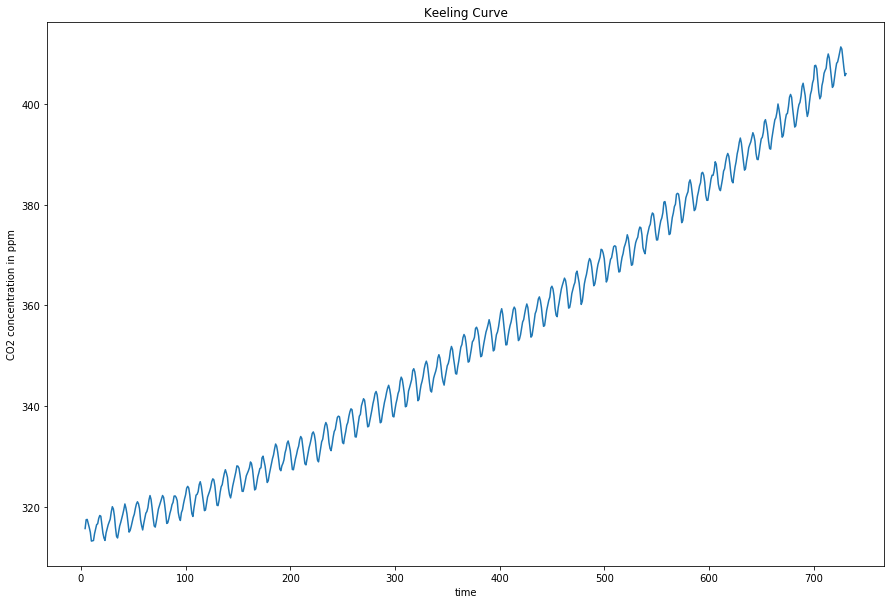

In [18]:
plt.figure(figsize=(15,10))
plt.plot(co2)
plt.title('Keeling Curve')
plt.xlabel('time')
plt.ylabel('CO2 concentration in ppm')
plt.show()

When we plot the date we can easily see the upward trend. The increase also is speeding up with time. It has gone from less then 320 ppm in 1958 to more then 400 today. This is about close of a third of increase in 60 years. There is also a strong seasonal component on an yearly basis. The concentration tends to peak in spring mostly in May and then decline in summer and bottom out in September. This is due to the greening of temperate forests in the northern hemisphere (most of the forest a situated in the north) and they sequence CO2 vie photosynthesis. There are also random factors such as like the Pacific Decadal Oscillation. El Nino years tend to have larger increases. For more information see here. https://en.wikipedia.org/wiki/Pacific_decadal_oscillation. There are also other factors like economic cycles and large volcanic eruptions. 
<br>
A popular approach to model such development is the Holt-Winters model, for more information on the subject see here https://otexts.org/fpp2/holt-winters.html. But we will concentrate on neural networks this time.

In [19]:
co2.count()

723

We split the data into train_set all but the last 12 values and a test set the values for last year.

In [20]:
train_set = co2.iloc[:711]

In [21]:
test_set = co2.iloc[711:]

## Batch Function
The neural network train set is going to be fed with batches, so we will create a next_batch function, to take the train set, the batch size and the steps that returns a reshaped batches. We start from a random position.

In [22]:
def next_batch(training_data,batch_size,steps):
    
    # start from a random starting point for each batch
    rand_start = np.random.randint(0,len(training_data)-steps) 

    # Create Y data for time series in the batches
    y_batch = np.array(training_data[rand_start:rand_start+steps+1]).reshape(1,steps+1)

    return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) 

## Basic LSTM cell
We have time series data, so the future values depend on the past values. We will use the RNN (recurrent neural network). One of the most popular types developed in the late 90s is LSTM or Long Short Term Memory. For more information check here http://colah.github.io/posts/2015-08-Understanding-LSTMs/. 
<br>
We start with the following parameters, everyone can change the values to try out different outcomes.

In [23]:
num_inputs = 1
num_time_steps = 12
num_neurons = 100
num_outputs = 1
learning_rate = 0.03 
num_train_iterations = 4000
batch_size = 1

The X and Y placeholders are set with a float32, and withe the shape None, number of time steps and number of inputs, or outputs respectively for y. 

In [24]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

The cell is created with the Output Projection Wrapper is going to be used with the Basic LSTM cell with an activation function ReLu.

In [25]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu),
    output_size=num_outputs) 

Now we pass in the cell variable into tf.nn.dynamic_rnn, along with your first placeholder X.

In [26]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
# get the ouputs and the state

### Loss Function and Optimizer
The Mean Squared Error Loss Function is used and it is minimized an AdamOptimizer.

In [27]:
loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

Initiation of the the global variables.

In [28]:
init = tf.global_variables_initializer()

Create a saver for the model.

In [29]:
saver = tf.train.Saver()

### Session
We load the session and print the MSE on every 100 steps and save it in the error list. Lastly we save the model as ./LSTMmodel

In [30]:
error = []
with tf.Session() as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = next_batch(train_set,batch_size,num_time_steps)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch}) # we pass a feed dictionary with the batches
            print(iteration, "\tMSE:", mse)
            error.append(mse)
    
    # Save Model for Later
    saver.save(sess, "./LSTMmodel")

0 	MSE: 104691.51
100 	MSE: 41.33569
200 	MSE: 20.896723
300 	MSE: 11.607898
400 	MSE: 12.795909
500 	MSE: 21.7078
600 	MSE: 78.48446
700 	MSE: 21.00772
800 	MSE: 4012.907
900 	MSE: 54.797012
1000 	MSE: 5.400862
1100 	MSE: 5.9718614
1200 	MSE: 10.95897
1300 	MSE: 7.2357545
1400 	MSE: 63.508503
1500 	MSE: 35.762882
1600 	MSE: 12.054019
1700 	MSE: 27.530197
1800 	MSE: 71.72806
1900 	MSE: 37.235126
2000 	MSE: 63.514843
2100 	MSE: 91.99105
2200 	MSE: 108.58115
2300 	MSE: 22.498503
2400 	MSE: 61.594982
2500 	MSE: 14.713127
2600 	MSE: 44.106678
2700 	MSE: 29.56426
2800 	MSE: 5.798653
2900 	MSE: 5.353233
3000 	MSE: 17.659689
3100 	MSE: 22.494814
3200 	MSE: 18.925653
3300 	MSE: 11.437095
3400 	MSE: 100.82474
3500 	MSE: 40.54217
3600 	MSE: 254.10039
3700 	MSE: 24.54579
3800 	MSE: 189.86641
3900 	MSE: 19.717997


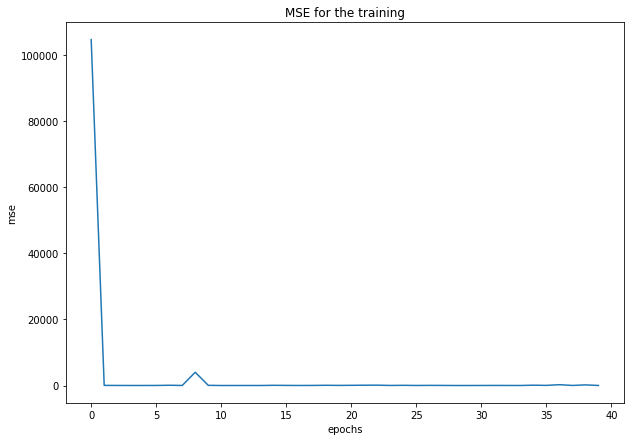

In [31]:
plt.figure(figsize=(10,7))
plt.plot(error)
plt.title('MSE for the training')
plt.ylabel('mse')
plt.xlabel('epochs')
plt.show()

We plot the MSE and see a rapid drop at the beginning. Due to the fact the first values are significantly larger then the later we don't see much change there.

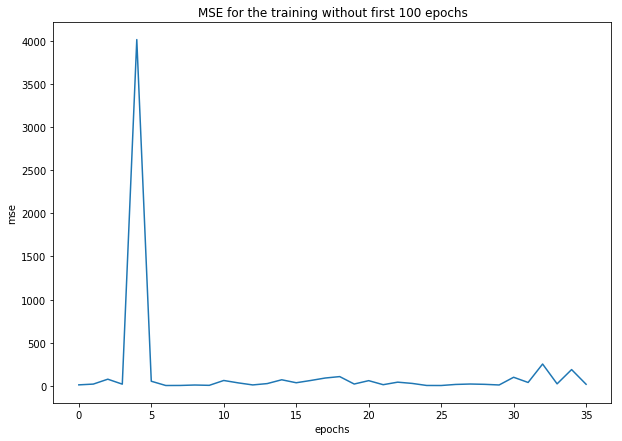

In [32]:
plt.figure(figsize=(10,7))
plt.plot(error[4:])
plt.title('MSE for the training without first 100 epochs')
plt.ylabel('mse')
plt.xlabel('epochs')
plt.show()

Now we remove the first 4 MSE in the error list. We see that there is no dramatic change anymore.

### Predicting Values 

We print the test set.

In [33]:
test_set

720    405.17
721    406.75
722    408.05
723    408.34
724    409.26
725    410.31
726    411.31
727    410.88
728    408.90
729    407.10
730    405.59
731    406.00
Name: CO2, dtype: float64

We now use the model to generate 12 new values to measure them against the test set.

In [34]:
with tf.Session() as sess:
    
    # restore the model via the saver
    saver.restore(sess, "./LSTMmodel")

    train_seed = list(train_set[-12:])
     
    for iteration in range(12):
        X_batch = np.array(train_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        train_seed.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./LSTMmodel


Print the train_seed.

In [35]:
train_seed

[403.64,
 404.55,
 406.07,
 406.64,
 407.06,
 408.95,
 409.91,
 409.12,
 407.2,
 405.24,
 403.27,
 403.64,
 405.00867,
 406.67136,
 407.5014,
 407.98978,
 408.837,
 411.45963,
 411.31778,
 411.0932,
 407.87048,
 406.785,
 403.4019,
 406.73233]

In [36]:
len(train_seed)

24

In [37]:
gen = train_seed[12:]

We now get the last 12 values, the generated values. Create a copy of the test set and make it to a dataframe. Lastly we add a new column with the generated data.

In [38]:
test_copy = test_set.copy(deep=True)

In [39]:
test_copy = pd.DataFrame(test_copy)

In [40]:
test_copy['Generated'] = gen

In [41]:
test_copy

,CO2,Generated
720,405.17,405.008667
721,406.75,406.671356
722,408.05,407.501404
723,408.34,407.989777
724,409.26,408.837006
725,410.31,411.459625
726,411.31,411.317780
727,410.88,411.093201
728,408.90,407.870483
729,407.10,406.785004


### Evaluate the predictions
We plot the 2 columns on the same plot. There are some differences, that are not to large, but we seem to getting the trend and the seasonality. This is the best performing model so far. I have tried other algorithms, but none come so close to this one. Some are very far off, others capture to some extent the seasonality. 3 algorithms have been displayed.

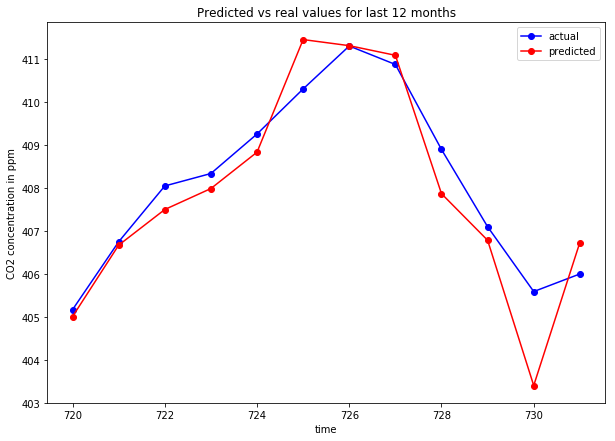

In [42]:
plt.figure(figsize=(10,7))
plt.plot(test_copy['CO2'], marker='o', color='blue', label='actual')
plt.plot(test_copy['Generated'], marker='o', color='red', label='predicted')
plt.legend(loc='upper right') 
plt.title('Predicted vs real values for last 12 months')
plt.xlabel('time')
plt.ylabel('CO2 concentration in ppm')
plt.show()


We will try other architecture in Part 2 and Part 3 one a different Jupyter Notebook. Due to the fact the preprocessing and EDA has already been done, we will not go into much detail there.

### Conclusion
Most of the models don't perform very well. More deep networks should be tried to see is they perform better like https://machinelearningmastery.com/stacked-long-short-term-memory-networks/.

### References
1. https://stackoverflow.com/
2. https://github.com/ageron/handson-ml/blob/master/14_recurrent_neural_networks.ipynb
3. Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems Aurélien Géron 2017